Copyright 2021 Exa Research, LLC

# Radar Cross Section (RCS) Modeling

A common SSA question is "What is the RCS of an object with a certain diameter?" Or put differently,  "What is the RCS of an object of a certain size as seen by a radar operating at this frequency?" Once we know the RCS, we can then start to figure out whether the radar could actually detect it by applying the standard radar link budget equations (out of scope for this document). We are also interested in knowing what size object could be detected if we know our radar can sense a certain RCS. The RCS is a function of the size, shape, orientation, material properties, and the frequency of the radar. In practice we rarely know these parameters - even for cooperative, well behaved objects. 

What we'll do is use the NASA Size Estimation Model (SEM) from [[1]](#ref_1) which derives a mechanism for mapping between RCS and physical "size". When we talk about size in the this document we'll use their definition: 

> "The characteristic length [size] of an object is defined as the average of the largest dimensions for an object measured along three orthogonal axes. The first axis was chosen to coincide with the largest dimension, the second axis to coincide with the largest dimension in plane orthogonal to the first axis, and the third axis to be orthogonal to the first two axes."

The model allows us to calculate the relationship between the wavelength of the radar and the size of the object. Following the definitions used in the NASA SEM we can say that when the wavelength $\lambda$ is much smaller than the size of the object that the radar is operating in the "Optical" region. If $\lambda$ is greater than the object size then it's operating in the "Rayleigh" region. Between these extremes it's in the "Mie Resonance" region. With that in mind the model establishes some convenient variables 

$$
\begin{align}
z & = \frac{\text{RCS}}{\lambda^2} \\
x & = \frac{\text{d}}{\lambda} \\
\lambda & = \text{wavelength} \\
d & = \text{diameter}
\end{align}
$$

and uses them to define operating curves.

$$
\begin{align}
x & = \sqrt{\frac{4z}{\pi}} & \text{ for }z>5 & \text{, Optical Region} \\
x & = \sqrt[6]{\frac{4z}{9\pi^5}} & \text{ for }z<0.03 & \text{, Rayleigh Region} \\
x & = g(z) & \text{ for }0.03 < z < 5 & \text{, Mie Resonance Region} \\
\end{align}
$$

where $g(z)$ is a piecewise continous approximation function. Note that $z$ in these equations is expressed in normal linear scale units, not dB. If we substitute these equations into each other we can see that when operating in the optical regime the RCS is independent of the wavelength and is simply the surface area of a sphere.

$$
\text{RCS} = \pi (d/2)
$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import scipy.constants
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator

# My custom code
import radar

%reload_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Gudea'})

With this model we can plot the normalized RCS against the normalized diameter and reproduce Figs. 3.2 (log scale) and 3.3 (dB scale) from [[1]](#ref_1) just to make sure we have things coded up properly.

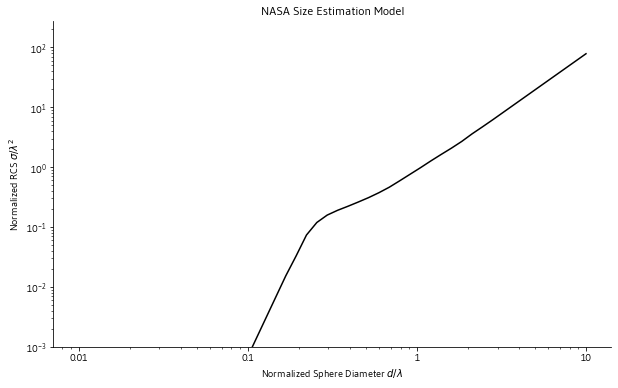

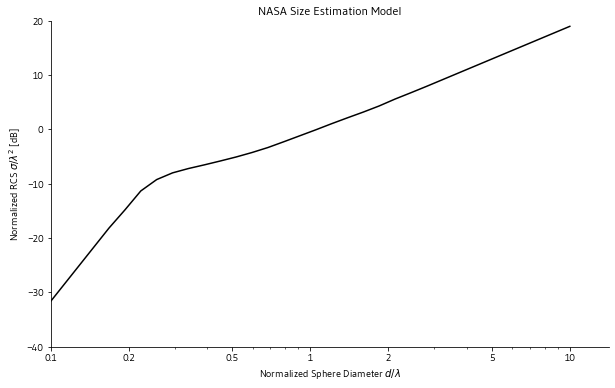

In [2]:
# Generate the data

x = np.logspace(-2, 1)
z = radar.norm_diameter_to_norm_rcs(x)
z_db = 10*np.log10(z)

# Reproduce Fig. 3.2

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, z, color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ymin=1e-3)
ax.set_xlabel('Normalized Sphere Diameter $d/\lambda$')
ax.set_ylabel('Normalized RCS $\sigma/\lambda^2$')
ax.set_title('NASA Size Estimation Model')
ax.xaxis.set_major_formatter(formatter)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

# Reproduce Fig. 3.3

locator = LogLocator(base=10, subs=(0.2, 0.5, 1))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, z_db, color='black')
ax.set_xscale('log')
ax.set_xlim(xmin=0.1)
ax.set_ylim(ymin=-40, ymax=20)
ax.set_xlabel('Normalized Sphere Diameter $d/\lambda$')
ax.set_ylabel('Normalized RCS $\sigma/\lambda^2$ [dB]')
ax.set_title('NASA Size Estimation Model')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(locator)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

## Examining Some SSA Radars

Now that we know our model implementatation looks good, let's use it to explore the capabilities of some typical space surveillance radars. We'll start at the low frequencies and work our way up the frequency bands, looking at a typical SSA radar that operates in each band and calculate the RCS for a variety of sphere sizes. 

In [3]:
df = pd.read_excel("radars.xlsx")
radar_list = ['GRAVE', 'Haystack', 'Cobra Dane', 'Eglin', 'TIRA (Ku)', 'HUSIR', 'Thoth Earthfence', 'LeoLabs KSR']
radars = df[df['Name'].isin(radar_list)].sort_values('Frequency (MHz)', ascending=False)
radars[['Name', 'Network', 'Frequency (MHz)', 'Band']].style.hide_index()

Name,Network,Frequency (MHz),Band
HUSIR,SSN,96000.000000,W
TIRA (Ku),EU SST,16700.000000,Ku
Haystack,SSN,10000.000000,X
Thoth Earthfence,Thoth,5700.000000,C
LeoLabs KSR,LeoLabs,2950.000000,S
Cobra Dane,SSN,1300.000000,L
Eglin,SSN,442.000000,UHF
GRAVE,EU SST,143.050000,VHF


Let's look at one of the classic SSA radars in particular, the US Space Force Space Surveillance Network (SSN) AN/FPS-85 radar at Eglin AFB, Florida, USA, operating at 422 MHz. Other radars operating at similar UHF frequencies include PARCS, Altair, the various PAVE PAWS/UEWR phased array radars, the EU's BIRALES, and the Poker Flats Incoherent Scatter Radar (PFISR).

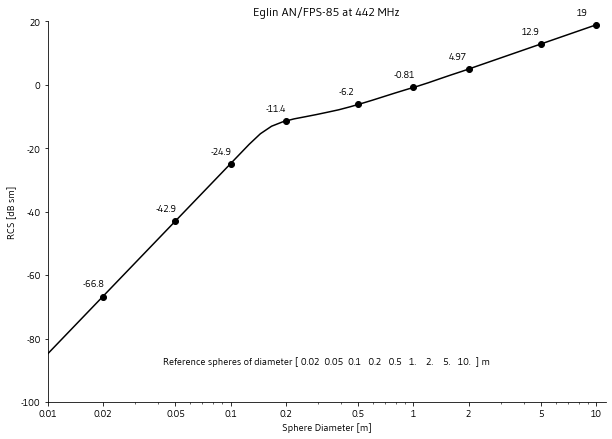

In [4]:
radar.plot_rcs(442e6, title='Eglin AN/FPS-85 at 442 MHz');
plt.savefig('eglin.png', dpi=300, facecolor='white')

We can see that it's performance really starts to fall off as we get to objects below 20 cm. Luckily it can compensate for this with power by operating at a peak transmit power as high as 32 MW (75 dBW)! Comparing that with the German TIRA radar operating in L-band which has a peak power of 2 MW (63 dBW).

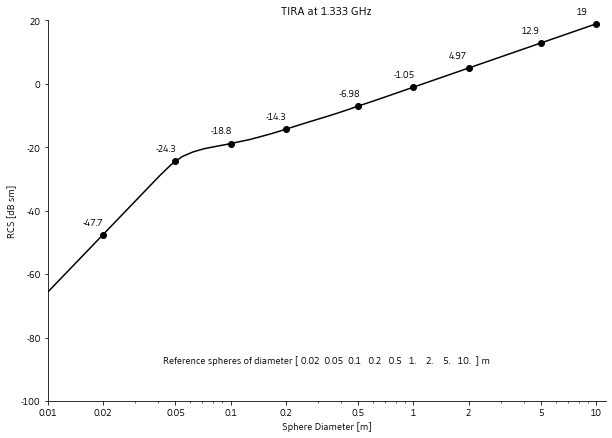

In [5]:
radar.plot_rcs(1330e6, title='TIRA at 1.333 GHz');

A 10 cm sphere tracked by Eglin has an RCS of -25.7 dBsm whereas TIRA would see it having an RCS of -18.8 dBsm. TIRA's higher frequency advantage gains it ~7dB of performance over Eglin, but Eglin can compensate with it's additional 12 dBW of power. Note that we are ignoring all the other practical aspects of a radar such as the pulse width, duty cycle, number of pulses being integrated, the waveform that's used, how many targets are being tracked simultaneously, etc. - it's not just a pure frequency vs. power trade-off.

We can overlay the individual curves for our set of SSA radars to produce a composite RCS plot. The individual lines are sorted in decreasing frequency order. The HUSIR, TIRA (in Ku-band mode), HAYSTACK, and Thoth Earthfence radars are all clearly operating in the optical (or near-optical) regime. Note that their primary purpose for the first three of these is imaging, not debris tracking. Imaging requires operating at the higher frequencies. 

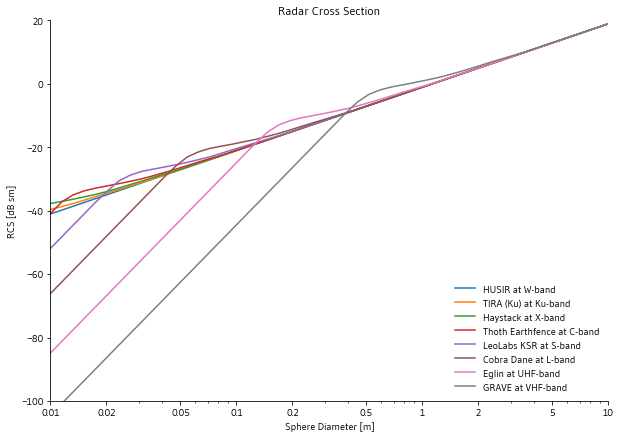

In [6]:
fig, ax = plt.subplots(figsize=(10,7))

# Default diameters range is 0.01 to 10 meters. We'll use these to 
# plot the background smooth curve.

diameter = np.logspace(-2, 1)
for i, r in radars.iterrows():
    frequency = r['Frequency (MHz)'] * 1e6
    rcs = 10*np.log10(radar.diameter_to_rcs(frequency, diameter))
    ax.plot(diameter, rcs, label=f"{r['Name']} at {r['Band']}-band")

locator = LogLocator(base=10, subs=(0.2, 0.5, 1))
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

ax.set_xscale('log')
ax.set_xlabel('Sphere Diameter [m]')
ax.set_ylabel('RCS [dB sm]')
ax.set_xlim(xmin=0.01, xmax=10)
ax.set_ylim(ymin=-100, ymax=20)
ax.set_title('Radar Cross Section')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(locator)
    
ax.legend(loc='lower right', frameon=False)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
fig.savefig('multiple radars.png', dpi=300, facecolor='white')

# General RCS plot

We can examine how the RCS varies as a function of diameter and frequency by generating a heatmap over a range of frequencies. 

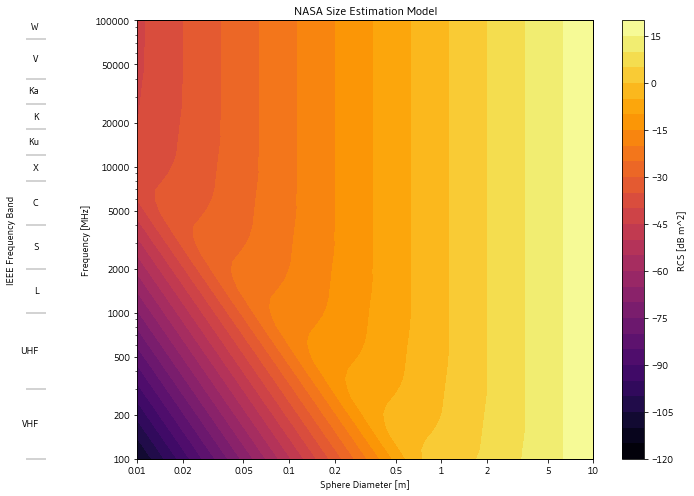

In [7]:
diameter = np.logspace(-2, 1, 50)
frequency_mhz = np.logspace(2, 5, 50)
frequency = frequency_mhz * 1e6

dv, fv = np.meshgrid(diameter, frequency)
rcs_db = 10*np.log10(radar.diameter_to_rcs(fv, dv))

# Plot the results
xlocator = LogLocator(base=10, subs=(0.2, 0.5, 1))
ylocator = LogLocator(base=10, subs=(0.2, 0.5, 1))
formatter = FuncFormatter(lambda x, _: '{:.16g}'.format(x))

db_contours = np.arange(-120, 25, step=5)
fig, ax = plt.subplots(figsize=(10,7))
cs = ax.contourf(diameter, frequency_mhz, rcs_db, levels=db_contours, cmap='inferno')
ax.set_xlabel('Sphere Diameter [m]')
ax.set_ylabel('Frequency [MHz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(xlocator)
ax.yaxis.set_major_formatter(formatter);
ax.yaxis.set_major_locator(ylocator)
ax.set_title('NASA Size Estimation Model')
cb = fig.colorbar(cs)
cb.set_label('RCS [dB m^2]')

# now set up parallel axis for the frequency bands

freq_bands = ['VHF', 'UHF', 'L', 'S', 'C', 'X', 'Ku', 'K', 'Ka', 'V', 'W']
freq_ticks = [100, 300, 1000, 2000, 4000, 8000, 12000, 18000, 27000, 40000, 75000, 110000]

# calculate the mid-point of each band (in log scale) for drawing the labels
freq_log = np.log10(freq_ticks)
freq_mid = np.power(10, (freq_log[:-1] + freq_log[1:]) / 2)

axis_offset = -0.2
# Draw fat tick marks to delineate the frequency bands
ax_band_ticks = ax.twinx()
ax_band_ticks.spines['left'].set_position(('axes', axis_offset))
ax_band_ticks.set_yscale('log')
ax_band_ticks.set_yticks(freq_ticks)
ax_band_ticks.set_ylim(ymin=100, ymax=1e5)
ax_band_ticks.minorticks_off()
ax_band_ticks.yaxis.set_ticks_position('left')
ax_band_ticks.tick_params(axis='y', length=20, width=2, which='major', labelright=False, labelleft=False, color='lightgrey')
ax_band_ticks.spines['left'].set_visible(False)

# Draw the band identifiers in between the fat tick marks
ax_band = ax.twinx()
ax_band.spines['left'].set_position(('axes', axis_offset))
ax_band.set_ylabel('IEEE Frequency Band')
ax_band.set_ylim(ymin=100, ymax=1e5)
ax_band.set_yscale('log')
ax_band.set_yticks(freq_mid)
ax_band.set_yticklabels(freq_bands, fontdict={'verticalalignment':'center', 'horizontalalignment':'right'})
ax_band.tick_params(axis='y', which='both', right=False, left=False)
ax_band.minorticks_off()

ax_band.yaxis.set_ticks_position('left')
ax_band.yaxis.set_label_position('left')
ax_band.tick_params(left=False)
ax_band.spines['left'].set_visible(False)

fig.tight_layout()
fig.savefig(r'RCS Contour.png', bbox_inches='tight', facecolor='white', dpi=300)
fig.savefig(r'RCS Contour.svg', bbox_inches='tight')

In reality we can't use just any frequency we want as the usage is highly regulated by the International Telecommunications Union (ITU) and within the US the Federal Communications Commission (FCC). The FCC publishes a nice chart showing the frequency allocations in the US [[4]](#ref_4) - search for the blocks marked "Radiolocation". Canada publishes a similar document [[5]](#ref_5). 

Clearly there are advantages to using a higher frequency radar when we want to observe smaller objects. Of course, things aren't that simple - the complications around producing the relevant hardware and designs that can accomodate high frequency operations become quite the challenge both physically and financially. Currently most operators are concerned with objects that are >2 cm in size, thus the recent focus on building radars that operate in L or S band.

# RCS Values from the Space Surveillance Network

The USSF Space Surveillance Network (SSN) reports a RCS range for the objects it tracks via the RCS_SIZE values published in the SATCAT file at www.space-track.org. In [[6]](#ref_6) we find the definition of the RCS_SIZE values: 

> RCS_SIZE has 3 values: Small (< 0.1m2), Medium (0.1m2 – 1m2), & Large (>1m2)

In the logarithmic dBm$^2$ scale these correspond to Small (< -10 dBm$^2$), Medium (-10 - 0 dBm$^2$), and Large (> 0 dBm$^2$). Prior to 2014 they use to publish actual RCS values, but have since changed there policy on doing so. Regardless, they unfortunately they don't specify what frequency the RCS values were observed at. Our earlier analysis showed that there can be quite a difference depending on the object size and radar frequency. Since most of the objects are LEOs we'll assume that the bulk of the observation data is performed by the UHF radars such as the PAVE PAWS sites or Eglin. Revisiting our Eglin radar performance plot and overlaying these definitions gives the figure below.


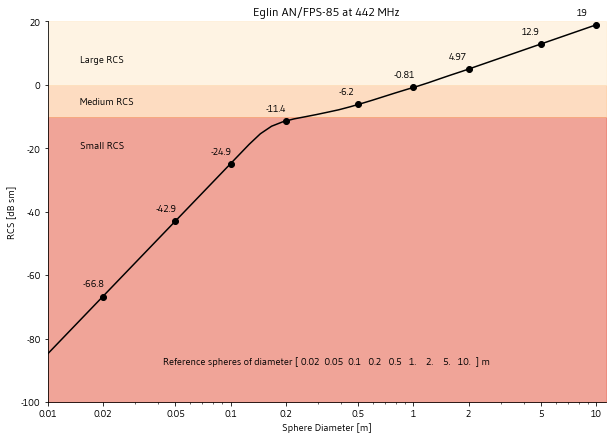

In [8]:
# Plot the normal Eglin graph
freq = 442e6
fig, ax = radar.plot_rcs(freq, title='Eglin AN/FPS-85 at 442 MHz')

# Add in the RCS_SIZE bands
x_range = ax.get_xlim()
y_range = ax.get_ylim()

alpha=0.5
# Small band
ax.fill_between(x_range, y_range[0], -10, zorder=0, color='#e34a33', alpha=alpha)
ax.annotate('Small RCS', xy=(0.015, -20))

# Medium band
ax.fill_between(x_range, -10, 0, zorder=0, color='#fdbb84', alpha=alpha)
ax.annotate('Medium RCS', xy=(0.015, -6))

# Large band
ax.fill_between(x_range, 0, y_range[1], zorder=0, color='#fee8c8', alpha=alpha)
ax.annotate('Large RCS', xy=(0.015, 7))

plt.savefig('eglin_with_rcs_size.png', dpi=300, facecolor='white')

"Small" RCS objects have an upper bound that is still within the optical regime for Eglin, so it's not surprising that we would expect this radar to collect on smaller objects. The good news is that the "Medium" and "Large" RCS objects are well within the optical regime, so their RCS values aren't expected to be frequency dependent and should be reasonably consistent regardless of the frequency of the radar (e.g. Haystack should report a similar RCS as Eglin).

## Planet Labs RCS Check

The recent batch of 48 Planet Labs "Flock 4S" satellites launched on 24 Jan 2021 have a size of roughly 10 x 10 x 30 cm (e.g. a classic 3U cubesat configuration). These are the "folded up for launch" dimensions. Once the solar panels are deployed it looks more like the image below. 

<img src="images/flock-1__2.jpg" alt="Planet Labs Flock Satellite" style="display:block; margin:auto"/>

<p style="text-align: center">
    <b>Flock Satellite</b><br>
    Courtesy Planet Labs, retrieved from <A href="https://space.skyrocket.de/doc_sdat/flock-1.htm">Gunter's Space Page</A>
</p>

The unfolded solar panel dimensions (from eyeballing the picture) are roughly 70 x 60 cm for an area of 0.42 m$^2$. The "knife edge" on view looking down the telescope (and parallel to the solar panels) has dimensions of roughly 10 x 10 cm for an area of 0.01 m$^2$. Depending on the viewing geometry between the radar and the satellite and the satellite's attitude at the moment we could expect the physical area (not RCS) to be in the range of 0.01 to 0.42 m$^2$. Converting these to dB scale yields a range from -10 to -3.7 dBm$^2$. Interpreting these as actual RCS values (with no justification) and checking the RCS_SIZE definitions used in the SATCAT we see that we might expect the reported RCS_SIZE values to be SMALL to MEDIUM. A quick check of the SATCAT shows that this is indeed the case, with 25 of 48 show values of SMALL and 23 as MEDIUM. It's not clear how frequently the 18 SPCS updates the RCS_SIZE values - e.g. these could be locked in values shortly after launch and depending on the particular geometry at that time - or they might updated more frequently as new tracks are obtained and flip-flopping between SMALL and MEDIUM would be expected.

Using the NASA SEM definitions we can calculate the "largest dimension"

$$
d = \frac{10 + 60 + 70}{3} = 46.7 \text{ cm} = 0.467 \text{ m}
$$

which roughly corresponds to our spherical diameter of 0.5 m, a predicted RCS of -6.2 dBm$^2$, and RCS_SIZE of MEDIUM. This is also consistent with the values reported in the SATCAT.


## SpaceBEE RCS Check

Thirty-six SpaceBEE satellites were launched at the same time as the Flock satellites noted above. The satellites have a 0.25U form factor with dimensions of 2.8 x 10 x 10 cm.  

<img src="images/spacebee-10__1.jpg" alt="Swarm Technology SpaceBEE Satellite" style="display:block; margin:auto"/>

<p style="text-align: center">
    <b>SpaceBEE Satellite</b><br>
    Courtesy Swarm Technology, retrieved from <A href="https://space.skyrocket.de/doc_sdat/spacebee-10.htm">Gunter's Space Page</A>
</p>

In this case the physical area varies from 0.0028 to 0.01 m$^2$ with corresponding logarithmic areas of -25.5 to -20 dBm$^2$.

Using the NASA SEM the "largest dimension" is

$$
d = \frac{2.8 + 10 + 10}{3} = 7.6 \text{ cm} = 0.076 \text{ m}
$$

which yields a RCS of -32 dBm$^2$. Unsurprisingly, the SATCAT lists all of these with RCS_SIZE of SMALL. But if we look at a later launch on 30 Jun 2021 we find that 28 SpaceBEE satellites were launched, 10 of which are marked as MEDIUM. This is likely an error, unless there's been a significant design change on some of these later satellites.

A natural follow up common question is "How small of an object can the SSN track?". As noted in [[7]](#ref_7)

> The SSN can often track debris smaller than 10 centimeters, but that depends on the shape and composition of the object, considered in concert with the size of
the debris. The lower limit for reliable tracking of an object is somewhere between 5 and 10 centimeters.

Looking at the plot and the reference points for the 5 and 10 cm objects we see that both are in the Rayleigh region, with the 5 cm object having an RCS that is 18 dB smaller. Getting another 18 dB of performance can be quite the challenge. But based on the SpaceBEE results it's clear that getting down to ~7.6 cm is possible.

# References

<a id='ref_1'></a>
[1] "Haystack and HAX Radar Measurements of the Orbital Debris Environment; 2003", Section 4.0.  https://www.orbitaldebris.jsc.nasa.gov/library/haystack_hax_radar2003.pdf

<a id='ref_2'></a>
[2] "Final Report of the Haystack Orbital Debris Data Review Panel", Technical Memorandum 4809, NASA, February 1998. See section 3.2.

<a id='ref_3'></a>
[3] "Haystack and HAX Radar Measurements of the Orbital Debris Environment: 2006-2012", Section 4.2. 

<a id='ref_4'></a>
[4] "United States Frequency Allocations", U.S. Department of Commerce, National Telecommunications and Information Administration, Office of Spectrum Management, October 2003, https://www.ntia.doc.gov/files/ntia/publications/2003-allochrt.pdf

<a id='ref_5'></a>
[5] "Radio Spectrum Allocations in Canada" https://www.ic.gc.ca/eic/site/smt-gst.nsf/vwapj/2018_Canadian_Radio_Spectrum_Chart.PDF/$FILE/2018_Canadian_Radio_Spectrum_Chart.PDF

<a id='ref_6'></a>
[6] "Space-Track FAQs" https://www.space-track.org/documentation#faq

<a id='ref_7'></a>
[7] "Crosslink ®The Aerospace Corporation magazine of advances in aerospace technology - Understanding Space Debris Causes, Mitigations, and Issues", Fall 2015, 
https://aerospace.org/sites/default/files/2019-04/Crosslink%20Fall%202015%20V16N1%20.pdf 